**Trinôme :**
* Julie BERNIER (28627942) / IPS TSDM
* Laurent LIN (3808422) / IPS SMR
* Mendrika Rakotobe (3708825) / IPS TSDM

# Présentation du code

Dans ce projet, nous avons étudié les différents mouvements d'un bras de robot à 2 articulations (articulé en E (l'épaule) de coordonnées $[0, 0]$, et en C (le coude)).  
Pour cela, nous avons d'abord écrit les équations de la trajectoire du point P (l'extrémité) dont on veut choisir la coordonnée. Nous avons alors implémenter les différentes méthodes qui nous étaient demandées dans un fichier _.py_ [document : Projet_Optimisation_BernierLinRakotobe_python.py].  
Nous avons créer des programmes permettant d'utiliser les 4 méthodes : 
* la fonction « root » (fonction _root_) ; 
* la fonction  « minimize » (fonction _minimize_) ; 
* la méthode du gradient (fonction _gradient_ + fonction _gradient_sans_ pour les recherches sans pas "adaptatif") ;
* et la méthode de Newton (fonction _newton_).  

Ce programme a été compléter avec des fonctions qui permettent l'affichage de différentes méthodes, et de différents styles d'affichage  :
* la fonction _show_ : qui permet d'afficher la position du bras robot pour la solution trouvée ;
* la fonction _affichage_ : qui permet d'afficher les positions successives de la solution lors des recherches, dans un graphe avec les isovaleurs de la fonction à minimiser (carré de la norme du résidu) ;
* la fonction _test_ : qui permet d'afficher les positions successives prises par le bras lors de la recherche des la solution (par les méthodes du gradient et de Newton) ; 
* la fonction _TroisD_ : qui permet d'afficher pour observer les isovaleurs en 3D.  

Les différentes fonctions fonctionnent différemment :
* fonction root : calcul direct de la racine d'une fonction vectorielle ($R(\theta)$);
* fonction minimize : calcul direct d'un minimum d'une fonction vectorielle ($||R(\theta)||^2$) ;
* méthode du gradient ( à pas fixe ) : à $\alpha$ fixé, on calcule à chaque tour $X_{n+1} = X_n -\alpha.\nabla J(X_n)$ ce qui consiste à se déplacer d'une certianes quantité dans la direction opposée au gradient de $J=||R(\theta)||^2$, et ainsi diminuer petit à petit la valeur de $J(X_n)$ jusqu'à ce que le déplacement soit négligeable;
* méthode de Newton : on calcule à chaque tour $\Delta X$ solution du système $H_J(X_n).\Delta X = -\nabla J(X_n)$ avec $J=||R(\theta)||^2$, ceci est dû à l'approximation de $J$ en $X_{n+1} = X_n + \Delta X$ avec le développement limité à l'ordre 2 : $\nabla J(X_n) + H_J(X_n).(X_{n+1}-X_n) = 0$.  

Afin d'utiliser ces méthodes, il est nécessaire d'implémenter les fonctions qui définissent les fonctions à annuler/minimiser et ses dérivées successives :
* fonction _residu(theta)_ : $R(\theta)$ ;
* fonction _normeResiduCarre(theta)_ : $J = ||R(\theta)||^2$ ;
* fonction _gradJ(theta)_ : $\nabla J = \overrightarrow {grad} (||R(\theta)||^2)$ ;
* fonction _J(theta)_ : $J = R(\theta)$ ;
* fonction _HessienneJ(theta)_ : $H_J = H(||R(\theta)||^2)$.


Dans la suite de ce notebook, nous redéfinissons les fonctions pour pouvoir tracer les différents exemples.

# Projet Optimisation: trajectoire d’un bras de robot à 2 articulations 


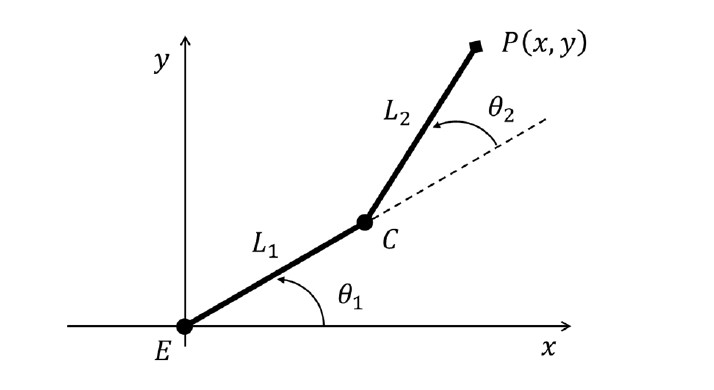
<center><i>Figure 1: Schéma de principe du bras articulé à deux degrés de liberté</i></center>

Le but du projet est de déterminer les positions angulaires $\theta_1(t)$ et $\theta_2(t)$ qui permettent de générer une trajectoire
$𝑃[x(t),y(t)]$ donnée. Il s’agit de ce que l’on appelle un problème « inverse », dans lequel il faut déterminer les
entrées d’un modèle (ici les angles $\theta_1$ et $\theta_2$) afin d’obtenir la sortie désirée (ici les coordonnées 𝑥 et 𝑦).   
Nous définissons donc la fonction résidu $R_X(\theta_1,\theta_2)$ définie par $R_X(\theta) = F(\theta) - X$ avec $X =\left(\begin{array}{c}x \\y\end{array} \right)$, $\theta = \left(\begin{array}{c}\theta_1 \\ \theta_2 \end{array} \right)$, et $F$ la fonction permettant exprimant le système d'équations non linéaires tel que $X = F(\theta)$.  
  
Les solutions que l'ont recherchent pour résoudre notre problème sont donc les racines de $R_X$. 

Par analyse géométrique du système à bras articulés, on trouve la fonction $F(\theta)$ définie comme :  
$F(\theta) = \left(\begin{array}{c}L_1cos(\theta_1) + L_2cos(\theta_1 + \theta_2) \\ L_1sin(\theta_1) + L_2sin(\theta_1 + \theta_2)\end{array} \right)$  
  
On a alors comme équations du résidu $R(\theta)$ :  
$R(\theta) = F(\theta) - X = \left(\begin{array}{c}L_1cos(\theta_1) + L_2cos(\theta_1 + \theta_2) - x \\ L_1sin(\theta_1) + L_2sin(\theta_1 + \theta_2) - y \end{array} \right)$

### Import des bibliothèques

In [1]:
import numpy as np
from math import cos, sin, sqrt, pi
import matplotlib.pyplot as plt
import scipy.optimize
from mpl_toolkits.mplot3d import Axes3D

Afin de montrer le bon fonctionnement des quatres méthodes demandées, nous allons implémenter le code avec les longueurs $L_1$ et $L_2$ valant 1 et les coordonnées $[0, 2]$. **On pourrait prendre un point plus intéressant pour observer si tous nos programmes fonctionnent bien**

In [2]:
# Initialisation
L1, L2 = 1, 1
L = [L1,L2]
a = 0
print()
b = 2
X = [a, b]
print("Les longueurs L1 et L2 valent", L)
print("Les coordonnées du points sont", X)


Les longueurs L1 et L2 valent [1, 1]
Les coordonnées du points sont [0, 2]


Avec ces valeurs de $(x,y)$ et $L_1$, $L_2$, si les méthodes fonctionnent correctement, on devrait trouver comme solution :
$\theta = \left(\begin{array}{c}\theta_1 \\ \theta_2 \end{array} \right) = \left(\begin{array}{c}\frac{\pi}{2} [2\pi] \\ 0 [2\pi] \end{array} \right)$ 

## Première méthode : Recherche des racines du résidu avec « root »

Dans cette première partie, nous utilisons la fonction « root » de la bibliothèque _scypy.optimize_ appliquée au résidu $R_X$.  
Cette fonction permet de trouver numériquement la solution du problème $R_X(\theta) = 0$.

Nous commençons par définir la fonction résidu $R_X$ :  

In [3]:
def residu(theta):
    return [L1 * np.cos(theta[0]) + L2 * np.cos(theta[0] + theta[1]) - a,
            L1 * np.sin(theta[0]) + L2 * np.sin(theta[0] + theta[1]) - b]

Afin de visualiser nos résultats trouvés numériquement, nous définissons une fonction *show* qui va permettre d'afficher la solution $\theta$ et la position $P(x,y)$, ainsi que de tracer la position des points $P$ et $C$ ( respectivement l'extrémité du bras, et le coude) dans le repère.

In [4]:
def show(theta):
    print(f"Solution du problème : {theta} (en radian) ou {theta*180/pi} (en degrés)")
    p1 = [L1 * np.cos(theta[0]) + L2 * np.cos(theta[0] + theta[1]), L1 * np.sin(theta[0]) + L2 * np.sin(theta[0] + theta[1])]
    pC1 = [L1* np.cos(theta[0]), L1 * np.sin(theta[0])]
    X_1 = [0, pC1[0], p1[0]]
    Y_1 = [0, pC1[1], p1[1]]
    print("La position P(x,y) =", p1)
    plt.figure()
    plt.plot(X_1, Y_1)
    plt.grid()
    for k in range (len(X_1)):
        plt.plot(X_1[k],Y_1[k], marker = 'o', markersize=10)

Afin de trouver la solution $\theta$ vérifiant l'équation $R(\theta) = 0$, on définit une fonction _root_ permettant d'utiliser _scipy.optimize.root_ et qui renvoie la solution _theta_, et aussi un boolean _success_ indiquant si la solution a bien était trouvée, ce qui permet de vérifier si la solution renvoyée est bien solution de $R(\theta)=0$.

In [5]:
# Scipy.optimize.root
def root(L, R0):
    solution = scipy.optimize.root(residu, R0)
    theta = solution.x
    success = solution.success
    return theta, success

Grâce aux fonctions définies précedemment, on peut enfin trouver la solution pour nos valeurs de $(x,y)$ et de $L_1$ et $L_2$.  
On calcule donc la solution avec la fonction _root_, on vérifie le succès de l'algorithme, et on affiche la position du bras avec cette méthode.

Avec .root
La solution a bien été trouvée ? False
Solution du problème : [ 14.13716695 -18.84955594] (en radian) ou [  810.00000042 -1080.00000084] (en degrés)
La position P(x,y) = [3.673940400591187e-16, 2.0]


Text(0.5, 1.0, 'Position du bras avec la méthode root')

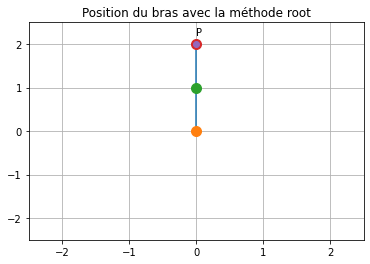

In [6]:
# Utilisation de la fonction root pour notre cas 
print("Avec .root")
R0 = [0, 0]
theta1, success1 = root(L, R0)
print("La solution a bien été trouvée ?", success1)
show(theta1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Position du bras avec la méthode root')

Après ce tracé, on constate que la fonction root a bien trouvée une solution pour ces valeurs de $(x,y)$ et $L_1$, $L_2$, en utilisant un point de recherche initial pour $\theta$ de $\theta_0 = [0,0]$.  
Cette solution correspond bien à la valeur recherchée de $[0,2]$ avec une précision de $10^{-16}$ (sur la coordonnées selon $x$), la fonction _root_ est donc très précise et est plus simple à implémenter.  
On constate également que la solution $\theta$ correspond à des angles très importants (plusieurs tours de 360° = 2$\pi$) et nécessite donc de passer par le modulo $[2\pi]$ si l'on veut contrôler le bras afin d'éviter de faire des tours pour arriver à la solution recherchée.

## Deuxième méthode : Recherche du minimum de la norme du résidu avec « minimize »

Dans cette deuxième partie, nous utilisons la fonction _scipy.optimize.minimize_ que l'on applique au carré de la norme du résidu. Cela permet de de passer d'un problème vectoriel $R(\theta)$ à un problème scalaire (à deux inconnues) $||R(\theta)||^2$.  
Avec $||R(\theta)||^2$ la norme du résidu au carré, on a donc $||R(\theta)||^2\geq0$. Et ainsi $||R(\theta)||^2$ possède au moins un minimum. La racine recherchée $\theta_0$ est telle que $R(\theta_0)=0$ donc $||R(\theta)||^2=0$ et donc $\theta_0$ est un minimum de $||R(\theta)||^2$. 
  
On calcule la fonction de la norme du residu au carré, en développant les calculs, on trouve :  
$||R(\theta)||^2=L_1^2 + L_2^2 + x^2 + y^2 + 2L_1L_2(cos\theta_1cos(\theta_1+\theta_2) + sin\theta_1sin(\theta_1+\theta_2)) - 2L_1(xcos\theta_1 + ysin\theta_1) - 2L_2(xcos(\theta_1+\theta_2) + ysin(\theta_1+\theta_2))$ 

On définit la fonction $||R(\theta)||^2=0$ par une fonction _normeResiduCarre_ :

In [7]:
def normeResiduCarre(theta):
    return L1 ** 2 + L2 ** 2 + a ** 2 + b ** 2 + 2 * L1 * L2 * (
                np.cos(theta[0]) * np.cos(theta[0] + theta[1]) + np.sin(theta[0]) * np.sin(theta[0] + theta[1])) - 2 * L1 * (
                       a * np.cos(theta[0]) + b * np.sin(theta[0])) - 2 * L2 * (
                       a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1]))

On définit une fonction _minimize_ permettant d'utiliser _scipy.optimize.minimize_ et qui renvoie la solution _theta_, et aussi un boolean _success_ indiquant si la solution a bien était trouvée, ce qui permet de vérifier si la solution renvoyée vérifie bien $||R(\theta)||^2$ minimum.

In [8]:
# Scipy.optimize.minimize
def minimize(L, R0):
    solution = scipy.optimize.minimize(normeResiduCarre, R0)
    theta = solution.x
    success = solution.success
    return theta, success

Grâce aux fonctions définies précedemment, on peut enfin trouver la solution pour nos valeurs de $(x,y)$ et de $L_1$ et $L_2$.  
On calcule donc la solution avec la fonction _minimize_, on vérifie le succès de l'algorithme, et on affiche la position du bras avec cette méthode.

Avec .minimize
La solution a bien été trouvée ? True
Solution du problème : [1.55470628 0.03217834] (en radian) ou [89.07810797  1.84368293] (en degrés)
La position P(x,y) = [1.764997145940056e-06, 1.9997411442328508]
Norme residu au carre :  6.700942378756736e-08


Text(0.5, 1.0, 'Figure avec la méthode minimize')

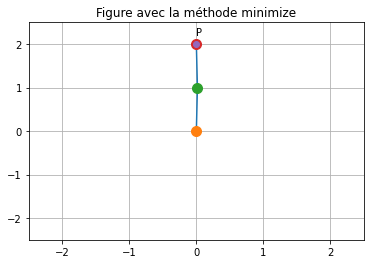

In [9]:
#Utilisation de la fonction minimize pour notre cas 
print("Avec .minimize")
R1 = [0,0]
theta2, success2= minimize(L, R1)
print("La solution a bien été trouvée ?", success2)
show(theta2)
print("Norme residu au carre : ", normeResiduCarre(theta2))
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Figure avec la méthode minimize')

Après ce tracé, on constate que la fonction root a bien trouvée une solution pour ces valeurs de $(x,y)$ et $L_1$, $L_2$, en utilisant un point de recherche initial pour $\theta$ de $\theta_0 = [0,0]$.  
Cette solution est très proche de celle recherchée $[90°[2\pi], 0°[2\pi]]$. On trouve alors une position $P(x,y)$ très proche de $[0,2]$ avec une précision de $10^{-4}$.  
La méthode par la fonction _minimize_ est donc précise, mais moins précise que la méthode avec _root_. Elle est également un peu plus compliquée que la fonction _root_, et nécessite le calcul de la norme du résidu au carré, qui peut devenir complexe si le système est plus compliqué (par exemple, un bras articulé à plus de degrés de liberté).  
D'autre part, on constate que les angles $\theta_1$, $\theta_2$ sont les premiers angles que la fonction "rencontre" : il s'agit de la mesure principale de la solution recherchée : $\theta = \left(\begin{array}{c}\theta_1 \\ \theta_2 \end{array} \right) = \left(\begin{array}{c}\frac{\pi}{2} \\ 0 \end{array} \right)$ avec une précision d'environ 1°, contrairement à la solution trouvée par _root_.

## Définition de la fonction pour afficher les méthodes avec leurs isovaleurs

On definit, ici, une fonction permettant l'affichage des différents "parcours" des methodes sur un graphes d'isovaleurs.

In [10]:
def affichage(tableau_X):
    M=[]
    L=[]
    xgrid=np.arange(-30,25, 0.01)
    ygrid=np.arange(-30,25, 0.01)
    [X,Y] = np.meshgrid(xgrid,ygrid)
    h=X.T,Y.T  #Nécessaire de faire la transposée afin d'avoir nos valeurs adéquats 
    Z=J(h)
    #Figure
    for k in (tableau_X):
        M.append(k[0])
        L.append(k[1])
    plt.figure()
    for k in range(len(tableau_X)):
        plt.plot(L[k],M[k], color = 'red', marker = 'o', markersize=5)
    plt.text(L[0], M[0], '  X0')
    plt.text(L[len(tableau_X)-1], M[len(tableau_X)-1], '  Xf')
    plt.contour(X,Y,Z,30)
    plt.plot(L,M)
    plt.xlabel(r"$\theta_2$")
    plt.ylabel(r"$\theta_1$")
    plt.grid()


## Troisième méthode : Recherche du minimum de la norme du résidu avec le gradient à pas adaptatif

Dans cette troisième partie, nous utilisons la méthode du gradient à pas fixe avec un mécanisme qui garantit que la norme du résidu diminue à chaque itération, méthode dite à pas "adaptatif".  
Pour celà, on doit vérifier que $\forall n \geq0: J(X{n+1})\lt J(X_n)$.  

On commence par implémenter une fonction _gradJ_ qui renvoie le gradient de $J$ avec $J$ la fonction à minimiser donc $J(\theta) = ||R(\theta)||^2$ :  
On a $J(\theta) = ||R(\theta)||^2$  
et $\nabla J(\theta) = \left(\begin{array}{c}2L_1(xsin\theta_1 - ycos\theta_1)+2L_2(xsin(\theta_1+\theta_2)-ycos(\theta_1+\theta_2)) \\ -2L_1L_2sin\theta_2 + 2L_2(xsin(\theta_1+\theta_2)-ycos(\theta_1+\theta_2)) \end{array} \right) $

In [11]:
# Méthode du gradient à pas fixe
def gradJ(theta):
    return [2 * L1 * (a * np.sin(theta[0]) - b * np.cos(theta[0])) + 2 * L2 * (
                a * np.sin(theta[0] + theta[1]) - b * np.cos(theta[0] + theta[1])),
            -2 * L1 * L2 * np.sin(theta[1]) + 2 * L2 * (a * np.sin(theta[0] + theta[1]) - b * np.cos(theta[0] + theta[1]))]

def J(theta):
    return L1 ** 2 + L2 ** 2 + a ** 2 + b ** 2 + 2 * L1 * L2 * (
                np.cos(theta[0]) * np.cos(theta[0] + theta[1]) + np.sin(theta[0]) * np.sin(theta[0] + theta[1])) - 2 * L1 * (
                       a * np.cos(theta[0]) + b * np.sin(theta[0])) - 2 * L2 * (
                       a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1]))    

Afin de satisfaire la condition $\forall n \geq0: J(X{n+1})\lt J(X_n)$, on doit vérifier à chaque tour de boucle si celle-ci est vérifier et modifier la valeur de alpha si ce n'est pas le cas, en la réduisant de moitié pour garantir la descente.  
On a donc la fonction _gradient_ suivante:

In [12]:
#Algorithme du gradient à pas fixe avec la règle empirique
def gradient(Xn, nMax, eps, alpha,dX):
    tabX = [Xn]
    n = 0
    converge = 0
    while (dX > eps) and (n < nMax):    
        Xn1 = []
        diff = []
        for i in range(len(Xn)):
            Xn1.append(Xn[i] - alpha * gradJ(Xn)[i])
            diff.append(Xn1[i] - Xn[i])
        while (J(Xn1)> J(Xn)):  #Mécanisme qui garantit que la norme du résidu diminue à chaque itération
            Xn1 = []
            diff = []
            alpha = alpha/2
            for i in range(len(Xn)):
                Xn1.append(Xn[i] - alpha * gradJ(Xn)[i])
                diff.append(Xn1[i] - Xn[i])
        dX = np.linalg.norm(diff)
        tabX.append(Xn1)
        Xn = Xn1
        n += 1
    converge = (dX <= eps)
    #Affichage de la solution pour le gradient
    print()
    print("Avec la methode du gradient à pas fixe")
    Xndeg = []
    for val in Xn:
        Xndeg.append(val*180/pi)
    print(f"Solution du problème : {Xn} (en radian) ou {Xndeg} (en degrés)")
    print("Convergence par méthode du gradient:", converge, f"en {n} itérations")
    print("Norme residu au carre : ", normeResiduCarre(Xn))
    return n, tabX

In [13]:
#Initialisation des variables
X0 = [0,0]
alpha = 0.1
eps = 1e-6
nMax = 100000
Xn = X0
dX = 1

In [14]:
#Utilisation de la fonction gradient
n, tabX = gradient(Xn,nMax,eps,alpha,dX)


Avec la methode du gradient à pas fixe
Solution du problème : [1.5530482307344768, 0.035495073941918746] (en radian) ou [88.98310900134518, 2.03371793037673] (en degrés)
Convergence par méthode du gradient: True en 19790 itérations
Norme residu au carre :  9.920533594609537e-08


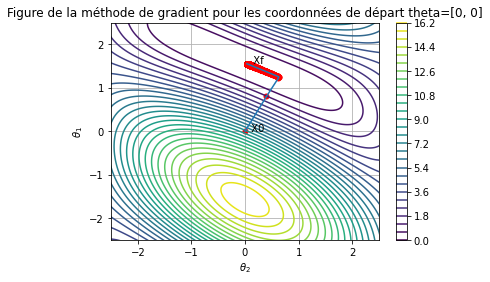

In [15]:
affichage(tabX)
plt.title(f'Figure de la méthode de gradient pour les coordonnées de départ theta={X0}')
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.colorbar()

On constate sur cette figure que la méthode du gradient tend bien vers un minimum de $||R(\theta)||^2$, elle tend vers les angles $\theta = \left(\begin{array}{c}\theta_1 \\ \theta_2 \end{array} \right) = \left(\begin{array}{c}\frac{\pi}{2} \\ 0 \end{array} \right)$ avec comme point initial $[0, 0]$, un $\alpha$ initial de 0.1 et une précision $\epsilon$ de $10^{-6}$.  
On trouve une norme du résidu au carré quasi nulle (de $10^{-7}$) et des valeurs d'angles correspondant à la mesure principale de la solution attendue avec une précision d'environ 1°.  
On constate, en faisant varier la valeur de $\alpha$ qu'avec une valeur supérieure à 0.1, on oscille autour de la solution, et pour un $\alpha$ plus faible, le nombre d'itérations pour converger sera trop grand, et le programme peut ne pas converger à cause de la limite $n_{max}$ du nombre d'itérations.  
De plus, on constate que le nombre d'itérations nécessaires pour atteindre ce résultat est très élevé (19790 itérations). Cette méthode nécessite donc beaucoup de temps.

On affiche maintenant le mouvement du bras pour les valeurs successives de $\theta$ prises lors de la recherche du minimum de la norme du résidu au carré par la méthode du gradient.

In [16]:
#Affichage du mouvement du bras robot 
def test(n,tabX):
    X_g = np.zeros((n,3))
    Y_g = np.zeros((n,3))
    pos_P = []
    pos_C = []

    for k in range (n):
        pos_P.append([L1*np.cos(tabX[k][0])+L2 * np.cos(tabX[k][0] + tabX[k][1]), L1 * np.sin(tabX[k][0]) + L2 * np.sin(tabX[k][0] + tabX[k][1])])
        pos_C.append([L1* np.cos(tabX[k][0]), L1 * np.sin(tabX[k][0])])
        X_g[k] = [0, pos_C[k][0], pos_P[k][0]]
        Y_g[k] = [0, pos_C[k][1], pos_P[k][1]]
        plt.plot(X_g[k],Y_g[k], marker = 'o', markersize=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()


Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode du gradient ')

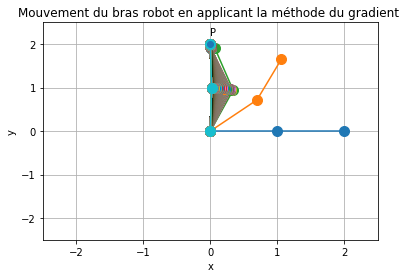

In [17]:
#Test avec le gradient à pas fixe appliquant la règle empirique
test(n,tabX)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode du gradient ')

On constate que pour la valeur $\alpha = 0.1$, le bras robot se déplace progressivement depuis la position horizontale correspondant à $\theta = [0,0]$ (la position initiale), jusqu'à atteindre la position voulue $\theta = [90°, 0]$.  
Avec une valeur de $\alpha$ plus grande, on aurait pu avoir des oscillations (amortie grâce à la règle empirique pour garantir la descente) autour de la position $\theta = [90°, 0]$. Et pour un $\alpha$ beaucoup plus petit, la position recherchée n'est parfois pas atteinte.

## Quatrième méthode : Recherche du minimum de la norme du résidu au carré par la méthode de Newton

Dans cette partie, nous utilisons la méthode de Newton afin de minimiser le carré de la norme du réside $R(\theta)$.  
  
On doit alors définir la matrice hessienne _HessienneJ_ de $J$, avec $J$ la norme du résidu au carré $J(\theta) = ||R(\theta)||^2$, et en calculant les dérivées secondes de $J$, on trouve :  
$H(J) =
\begin{pmatrix}
2L_1(xcos(\theta_1) + ysin(\theta_1)) + 2L_2(xcos(\theta_1 + \theta_2) + ysin(\theta_1 + \theta_2)) & 2L_2(xcos(\theta_1 + \theta_2) + ysin(\theta_1 + \theta_2))\\
2L_2(xcos(\theta_1 + \theta_2) + ysin(\theta_1 + \theta_2)) & -2L_1L_2cos(\theta_1) + 2L_2(xcos(\theta_1 + \theta_2) + ysin(\theta_1 + \theta_2))
\end{pmatrix}$

In [18]:
# Méthode de Newton
def HessienneJ(theta):
    return [[2 * L1 * (a * np.cos(theta[0]) + b * np.sin(theta[0])) + 2 * L2 * (
                a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1])),
             2 * L2 * (a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1]))],
            [2 * L2 * (a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1])),
             -2 * L1 * L2 * np.cos(theta[1]) + 2 * L2 * (a * np.cos(theta[0] + theta[1]) + b * np.sin(theta[0] + theta[1]))]]

On implémente maintenant la fonction _newton_ qui renvoie le nombre d'itération _n_ et un tableau _tabX_N_ contenant les différentes valeurs prises par $\theta$ pendant l'appel de la fonction. 

In [19]:
#Algorithme de recherche du minimum de la norme du résidu au carré par la méthode de Newton
def newton(Xn, n_Max, epsilon):
    n=0
    tabX_N = [Xn]
    dX = 1
    while (dX > eps) and (n < nMax):
        H = HessienneJ(Xn)
        gJ = [gradJ(Xn)[0], gradJ(Xn)[1]]
        deltaX_sol = np.matmul(np.linalg.inv(H),gJ)
        Xn = Xn - deltaX_sol
        tabX_N.append(Xn)
        dX = np.sqrt((deltaX_sol[0])**2+(deltaX_sol[1])**2)
        n += 1
    converge = (dX <= eps)
    print("Avec la methode de Newton    ")
    print("Convergence par méthode du gradient:", converge, f"en {n} itérations")
    Xndeg = []
    for val in Xn:
        Xndeg.append(val*180/pi)
    print(f"Solution du problème : {Xn} (en radiant) ou {Xndeg} (en degrés)")
    print("Norme residu au carre : ", normeResiduCarre(Xn))
    return n, tabX_N 

In [20]:
#Initialisation des variables
eps = 1e-5
nMax = 10000
X0 = [0.5, 0.5]

In [21]:
#Utilisation de la fonction newton
n_N, tabX_N =  newton(X0, nMax, eps)

Avec la methode de Newton    
Convergence par méthode du gradient: True en 29 itérations
Solution du problème : [1.57078920e+00 1.42549609e-05] (en radiant) ou [89.99959162545076, 0.000816749098491902] (en degrés)
Norme residu au carre :  0.0


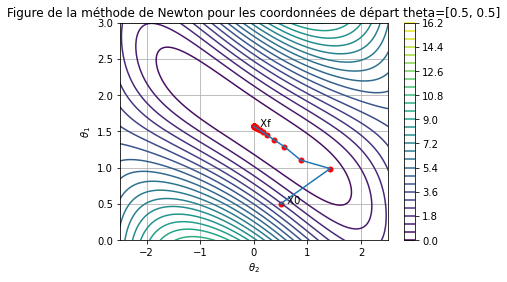

In [22]:
#Affichage du graphique avec isovaleurs
affichage(tabX_N)
plt.title(f'Figure de la méthode de Newton pour les coordonnées de départ theta={X0}')
plt.xlim(-2.5,2.5)
plt.ylim(0,3)
plt.colorbar()

On constate que la méthode de Newton permet bien de tendre vers le minimum attendu $\theta = \left(\begin{array}{c}\frac{\pi}{2} \\ 0 \end{array} \right)$ avec un point $\theta$ initial de $[0.5, 0.5]$, une précision $\epsilon = 10^{-5}$ et un nombre maximum d'itérations $n_{max} = 10000$.  
Cette méthode est très précise : erreur de $10^{-3}$ degré, et la norme du résidu au carré bien égale à 0.  
Un avantage important de la méthode de Newton est la rapidité : cette solution très précise a été atteinte en seulement 29 itérations (comparé à presque 20 000 itérations pour la méthode du gradient).

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de Newton')

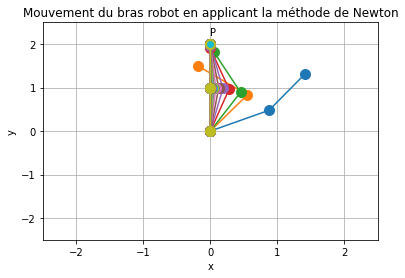

In [23]:
#Test avec Newton
test(n_N, tabX_N)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton')

On constate que dans ces conditions, le bras dépasse légèrement la solution au début, puis tend vers la position souhaité (bras verticale) progressivement.

##  Existence de problèmes sans solution 

Il existe des problèmes sans solutions. En effet dans notre cas de bras robot à deux longueurs, l'ensemble des solutions possibles se trouvent dans une couronne tel que $(L_1-L_2)^2 \le (a+b)^2 \le (L_1+L_2)^2$ où $x \in C$ et $C$ correspond à l'ensemble des solutions


Prenons le cas où $(a+b)^2\le(L_1-L_2)^2 $

In [24]:
# Initialisation
L1, L2 = 6, 2
L = [L1,L2]
a = 2
print()
b = 1
X = [a, b]
print("Les longueurs L1 et L2 valent", L)
print("Les coordonnées du points sont", X)
alpha = 0.1
eps = 1e-4
nMax = 100000
Xn = [0.1, 0.1]
dX = 1


Les longueurs L1 et L2 valent [6, 2]
Les coordonnées du points sont [2, 1]


Pour ce cas-là, nous allons observer le comportement des 4 méthodes :

Avec .root
La solution a bien été trouvée ? False
Solution du problème : [ 0.50153195 -3.11678096] (en radian) ou [  28.73566409 -178.57839446] (en degrés)
La position P(x,y) = [3.531783042092172, 1.8798658485295565]


Text(0.5, 1.0, 'Figure avec méthode root')

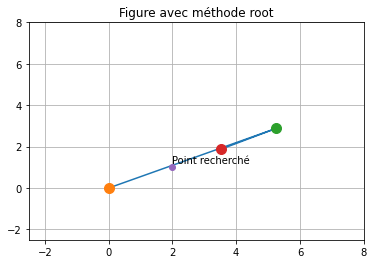

In [25]:
#Utilisation de la fonction root pour notre cas sans solution 
print("Avec .root")
R0 = [0, 0]
theta3, success3 = root(L, R0)
print("La solution a bien été trouvée ?", success3)
show(theta3)
plt.xlim(-2.5,8)
plt.ylim(-2.5,8)
plt.plot(2,1,'o')
plt.text(2, 1.2, 'Point recherché')
plt.title('Figure avec méthode root')

Le point légendé par 'Point recherché' correspond à la position que l'on souhaite atteindre. Le point en rouge correspond à l'extremité du bras (calculé avec la solution $\theta$ renvoyée par _root_), et le point en vert au coude du bras.  
On constate qu'avec la fonction _root_, le programme n'a pas pu trouver la solution (puisqu'il n'existe pas de racine). On remarque que la fonction renvoie $\theta$ qui permet de s'approcher au plus de la solution souhaitée (si $L_2$ était plus grande, on aurait pourrait atteindre le point 'P').

Avec .minimize
La solution a bien été trouvée ? True
Solution du problème : [0.46364774 3.14159271] (en radian) ou [ 26.56505861 180.00000312] (en degrés)
La position P(x,y) = [3.5777085805864384, 1.7888547488262452]
Norme residu au carre :  3.1114561800017917


Text(0.5, 1.0, 'Figure avec la méthode minimize')

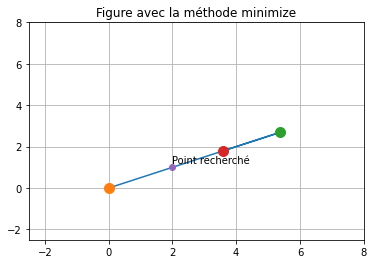

In [26]:
#Utilisation de la fonction minimize pour notre cas sans solution
print("Avec .minimize")
R0 = [0, 0]
theta4, success4 = minimize(L, R0)
print("La solution a bien été trouvée ?", success4)
show(theta4)
print("Norme residu au carre : ", normeResiduCarre(theta4))
plt.xlim(-2.5,8)
plt.ylim(-2.5,8)
plt.plot(2,1,'o')
plt.text(2, 1.2, 'Point recherché')
plt.title('Figure avec la méthode minimize')

On est dans la même configuration que pour la fonction _root_.  
Cependant, comme la fonction _minimize_ recherche le minimum du carré de la norme du résidu, ainsi, le programme affiche un succès de la recherche (puisqu'il s'agit bien du minimum dans l'ensemble des solutions possibles). Hors, la norme du résidu au carré n'est pas nulle (ou négligeable comme précédemment), il ne s'agit donc pas de la solution recherchée.  

In [27]:
#Utilisation de la fonction gradient
n, tabX = gradient(Xn,nMax,eps,alpha,dX)


Avec la methode du gradient à pas fixe
Solution du problème : [0.4635492554195756, 3.1414774992038472] (en radian) ou [26.559415931973486, 179.9934021396929] (en degrés)
Convergence par méthode du gradient: True en 23 itérations
Norme residu au carre :  3.111456265045483


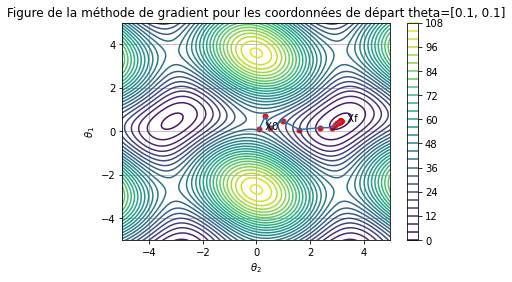

In [28]:
affichage(tabX)
plt.title(f'Figure de la méthode de gradient pour les coordonnées de départ theta={Xn}')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.colorbar()

On remarque que le programme permet bien de tendre vers un minimum comme les autres programmes précédents.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode du gradient ')

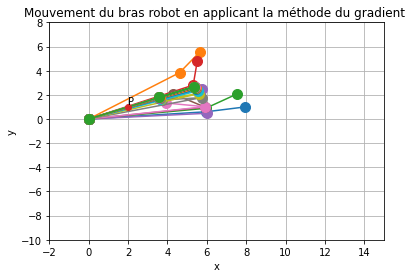

In [29]:
#Test avec le gradient à pas fixe applicant la règle empirique
test(n,tabX)
plt.xlim(-2,15)
plt.ylim(-10,8)
plt.plot(2,1,'o')
plt.text(2, 1.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode du gradient ')

On remarque que le programme replie petit à petit la partie $L_2$ du bras robot afin de minimiser la distance entre l'extrêmité du bras et le point recherché.

In [30]:
#Utilisation de la fonction newton
n_N, tabX_N =  newton(Xn, nMax, eps)

Avec la methode de Newton    
Convergence par méthode du gradient: True en 3 itérations
Solution du problème : [ 4.63647609e-01 -2.05479605e-18] (en radiant) ou [26.56505117707799, -1.1773114147789473e-16] (en degrés)
Norme residu au carre :  33.22291236000336


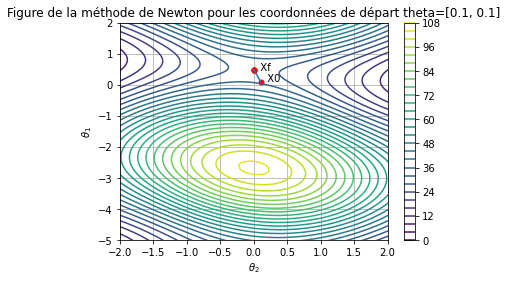

In [31]:
#Affichage du graphique avec isovaleurs
affichage(tabX_N)
plt.title(f'Figure de la méthode de Newton pour les coordonnées de départ theta={Xn}')
plt.xlim(-2, 2)
plt.ylim(-5, 2)
plt.colorbar()

Cependant, la méthode de Newton ne permet pas de tendre vers un minimum lorsqu'il n'existe pas de racine pour $R(\theta)$, on remarque que le programme tend vers un point-selle. Cette méthode n'est donc pas adaptée pour les problèmes pour lesquelles on n'a qu'un minimum mais pas de racines.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de Newton')

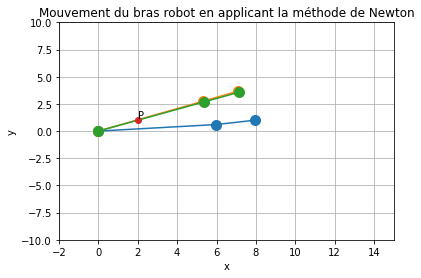

In [32]:
#Test avec Newton
test(n_N, tabX_N)
plt.xlim(-2,15)
plt.ylim(-10,10)
plt.plot(2,1,'o')
plt.text(2, 1.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton')

La méthode de Newton ne permet pas de minimiser la distance entre l'extremite du bras et le point recherché.  
L'angle $\theta_1$ tend bien vers la valeur recherchée (minimum du point-selle), mais $\theta_2$ reste à un maximum (maximum du point-selle).

Prenons le cas où $(a+b)^2\ge(L_1+L_2)^2 $

In [33]:
# Initialisation
L1, L2 = 5, 3
L = [L1,L2]
a = 10
print()
b = 3
X = [a, b]
print("Les longueurs L1 et L2 valent", L)
print("Les coordonnées du points sont", X)
alpha = 0.1
eps = 1e-3
nMax = 10000
Xn = [0.1, 0.1]
dX = 1


Les longueurs L1 et L2 valent [5, 3]
Les coordonnées du points sont [10, 3]


Avec .root
La solution a bien été trouvée ? False
Norme residu au carre :  5.9551500853414865
Solution du problème : [ 2.90756599e-01 -2.74675755e-04] (en radian) ou [ 1.66591260e+01 -1.57377615e-02] (en degrés)
La position P(x,y) = [7.664454121985007, 2.29262772387614]


Text(0.5, 1.0, 'Figure avec méthode root')

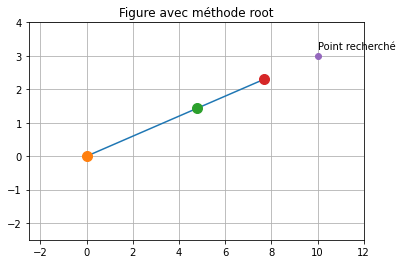

In [34]:
#Utilisation de la fonction root pour notre cas sans solution 
print("Avec .root")
R0 = [0, 0]
theta5, success5 = root(L, R0)
print("La solution a bien été trouvée ?", success5)
print("Norme residu au carre : ", normeResiduCarre(theta5))
show(theta5)
plt.xlim(-2.5,12)
plt.ylim(-2.5,4)
plt.plot(10,3,'o')
plt.text(10, 3.2, 'Point recherché')
plt.title('Figure avec méthode root')

De même que pour l'autre cas sans solution, la fonction _root_ ne trouve pas de solution mais retourne la solution la plus proche de celle recherchée (le minimum du résidu).

Avec .minimize
Solution du problème : [ 2.91456842e-01 -1.63333765e-07] (en radian) ou [ 1.66992469e+01 -9.35833540e-06] (en degrés)
La position P(x,y) = [7.66261031370963, 2.298782978062611]
Norme residu au carre :  5.955095857431331


Text(0.5, 1.0, 'Figure avec la méthode minimize')

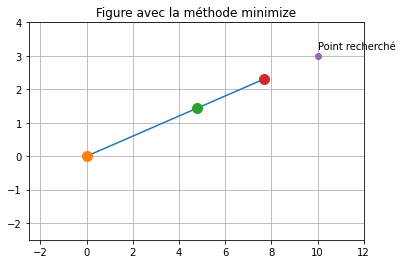

In [35]:
#Utilisation de la fonction minimize pour notre cas sans solution
print("Avec .minimize")
theta6, success6 = minimize(L, R0)
show(theta6)
print("Norme residu au carre : ", normeResiduCarre(theta6))
plt.xlim(-2.5,12)
plt.ylim(-2.5,4)
plt.plot(10,3,'o')
plt.text(10, 3.2, 'Point recherché')
plt.title('Figure avec la méthode minimize')

De même que précédemment, la fonction _minimize_ renvoie toujours un minimum (norme résidu au carré positive non nulle), ce qui correspond bien à la solution possible la plus proche de la solution recherchée, mais la fonction croit avoir trouvée le résultat exact recherché.

In [36]:
#Utilisation de la fonction gradient
n, tabX = gradient(Xn,nMax,eps,alpha,dX)


Avec la methode du gradient à pas fixe
Solution du problème : [0.2844864341140081, 0.017700391417692554] (en radian) ou [16.299872003459228, 1.0141577239633672] (en degrés)
Convergence par méthode du gradient: True en 42 itérations
Norme residu au carre :  5.956538726257392


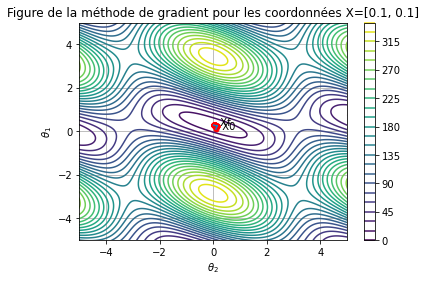

In [37]:
affichage(tabX)
plt.title(f'Figure de la méthode de gradient pour les coordonnées X=[0.1, 0.1]')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.colorbar()

Comme précédemment, la méthode du gradient permet de tendre vers le minimum mais ne peut pas trouver la solution.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode du gradient ')

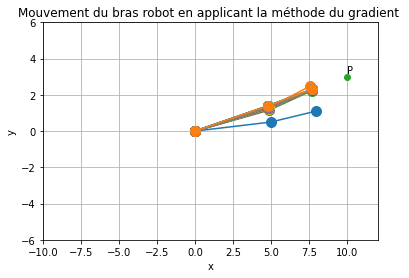

In [38]:
#Test avec le gradient à pas fixe applicant la règle empirique
test(n,tabX)
plt.xlim(-10,12)
plt.ylim(-6,6)
plt.plot(10,3,'o')
plt.text(10, 3.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode du gradient ')

La fonction gradient permet bien de minimiser la norme du résidu au carré lorsqu'il n'y a pas de solution.

In [39]:
#Utilisation de la fonction newton
n_N, tabX_N =  newton(X0, nMax, eps)

Avec la methode de Newton    
Convergence par méthode du gradient: True en 4 itérations
Solution du problème : [ 2.91456794e-01 -1.71577607e-12] (en radiant) ou [16.699244234034424, -9.830672724187185e-11] (en degrés)
Norme residu au carre :  5.9550958574312105


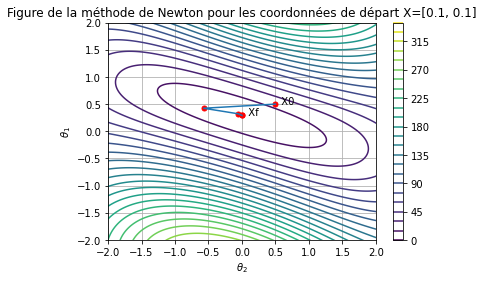

In [40]:
#Affichage du graphique avec isovaleurs
affichage(tabX_N)
plt.title('Figure de la méthode de Newton pour les coordonnées de départ X=[0.1, 0.1]')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de Newton')

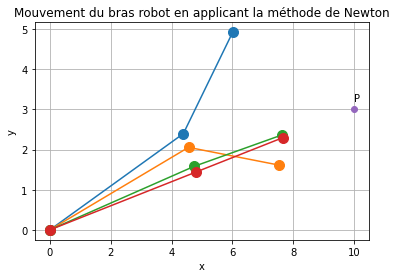

In [41]:
#Test avec Newton
test(n_N, tabX_N)
plt.plot(10,3,'o')
plt.text(10, 3.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton')

Cette fois, la méthode de Newton permet bien de minimiser la norme du résidu au carré.

Pour les fonctions _root_, _minimize_ ou la méthode du gradient, le programme renvoie la solution permettant de minimiser le résidu; la fonction _root_ permet de savoir si la solution a effectivement été trouvée ou s'il ne s'agit que d'un minimum.

## Existence de solutions non uniques 
Comme nous étudions des angles, les solutions sont sont $2\pi$ - périodiques : pour chaque solution $\theta$ la solution $\theta + 2k\pi$ (avec $k \in \mathbb{Z}$) est également solution, on peut donc trouver plusieurs solutions qui vont satisfaire la condition $R(\theta)=0$ ou  minimum de $||R(\theta)||^2$.

In [42]:
#Initialisation
L1, L2 = 1, 1
L = [L1,L2]
a = 0
print()
b = 2
X_non1 = [1, 1]
X_non2 = [3, 3]
X_non3 = [10, 10]
alpha = 0.1
eps = 1e-3
nMax = 10000
dX = 1

In [43]:
#Utilisation du gradient pour différents points de départ
n_non1, tabX_non1 = gradient(X_non1, nMax, eps, alpha,dX)
n_non2, tabX_non2 = gradient(X_non2, nMax, eps, alpha,dX)
n_non3, tabX_non3 = gradient(X_non3, nMax, eps, alpha,dX)


Avec la methode du gradient à pas fixe
Solution du problème : [1.3930662576825041, 0.35433051790051634] (en radian) ou [79.81681714729147, 20.301643228384254] (en degrés)
Convergence par méthode du gradient: True en 178 itérations
Norme residu au carre :  0.0009812914471178935

Avec la methode du gradient à pas fixe
Solution du problème : [1.7486538053453953, 5.928602411362989] (en radian) ou [100.19048287578214, 339.683896582182] (en degrés)
Convergence par méthode du gradient: True en 203 itérations
Norme residu au carre :  0.0009840846941138182

Avec la methode du gradient à pas fixe
Solution du problème : [8.0319547806631, 12.211558601343517] (en radian) ou [460.19711017192043, 699.6707691336621] (en degrés)
Convergence par méthode du gradient: True en 204 itérations
Norme residu au carre :  0.000986625648249806


On constate que ces trois valeurs possibles de points $\theta$ de départ permettent bien toutes de trouver une norme de résidu nulle (ou négligeable), mais pour des valeurs solutions $\theta_0$ différentes.

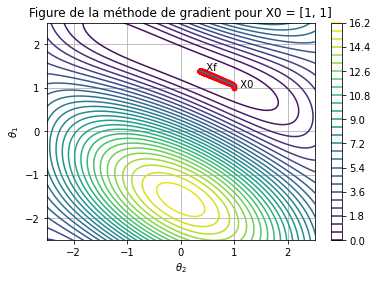

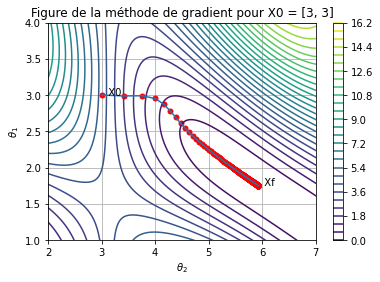

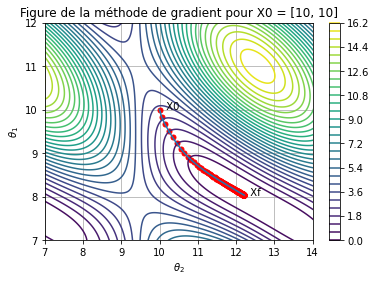

In [44]:
#Affichage de la méthode du gradient pour différentes solutions
affichage(tabX_non1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient pour X0 = [1, 1]')
plt.colorbar()

affichage(tabX_non2)
plt.xlim(2, 7)
plt.ylim(1, 4)
plt.title('Figure de la méthode de gradient pour X0 = [3, 3]')
plt.colorbar()


affichage(tabX_non3)
plt.xlim(7, 14)
plt.ylim(7, 12)
plt.title('Figure de la méthode de gradient pour X0 = [10, 10]')
plt.colorbar()
plt.show()

Ces différentes solutions possibles pour un résultat minimum pour la norme du résidu sont due au fait que notre recherche est faite sur des angles et est donc $2\pi$ - périodique.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')

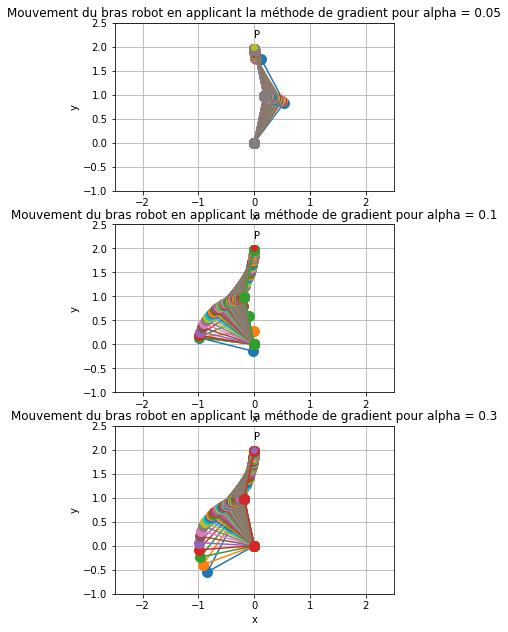

In [45]:
#Observation du mouvement du bras robot lorsque le gradient suit la règle empirique
plt.figure(figsize=(5, 10.5))
plt.subplot(3,1,1)
test(n_non1, tabX_non1)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.05')

plt.subplot(3,1,2)
test(n_non2, tabX_non2)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.1')


plt.subplot(3,1,3)
test(n_non3, tabX_non3)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')

Toutes ces solutions effectuent un mouvement différent mais elles arrivent toujours au point $P(x,y)$ demandé.

## Affichage 3D du problème d'optimisation

In [63]:
#Code arbitraire pour observer les isovaleurs en 3D
def TroisD(J):
    M=[]
    L=[]

    x=np.arange(-5,5, 0.1)
    y=np.arange(-5,5, 0.1)
    [X,Y] = np.meshgrid(x,y)
    H=X,Y
    Z_1=J(H)

    #Figure de la fonction en 3D
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, Z_1, 50, cmap='rainbow')
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel('J')
    ax.set_title('3D contour')
    ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('Figure 3D du problème d optimisation')

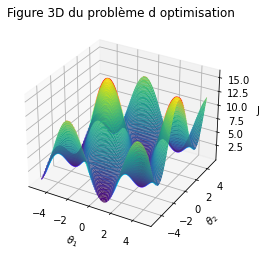

In [64]:
#Application de l'affichage 3D
TroisD(J)

## Exemple:  Importance du pas de la méthode du gradient 


Pour notre exemple nous allons prendre différentes valeurs de $\alpha$ auquel nous allons observer l'effet du pas de recherche sur le gradient à pas fixe. Ensuite, nous allons observer l'effet de la règle empirique sur notre recherche de solution.

In [48]:
#Initialisation
X0 = [a, b]
alpha = [0.05, 0.1, 0.3]
eps = 1e-3
nMax = 10000
Xn = X0
dX = 1

In [49]:
#Algorithme du gradient à pas fixe sans la règle empirique
def gradient_sans(Xn, nMax, eps, alpha,dX):
    tabX = [Xn]
    n = 0
    converge = 0
    while (dX > eps) and (n < nMax):    
        Xn1 = []
        diff = []
        for i in range(len(Xn)):
            Xn1.append(Xn[i] - alpha * gradJ(Xn)[i])
            diff.append(Xn1[i] - Xn[i])
        dX = np.linalg.norm(diff)
        tabX.append(Xn1)
        Xn = Xn1
        n += 1
    converge = (dX <= eps)
    #Affichage de la solution pour le gradient
    print()
    print("Avec la methode du gradient à pas fixe")
    Xndeg = []
    for val in Xn:
        Xndeg.append(val*180/pi)
    print(f"Solution du problème : {Xn} (en radian) ou {Xndeg} (en degrés)")
    print("Convergence par méthode du gradient:", converge, f"en {n} itérations")
    print("Norme residu au carre : ", normeResiduCarre(Xn))
    return n, tabX

In [50]:
#Test avec le gradient à pas fixe sans la règle empirique
n_1, tabX_1 = gradient_sans(Xn, nMax, eps, alpha[0],dX)
n_2, tabX_2 = gradient_sans(Xn, nMax, eps, alpha[1],dX)
n_3, tabX_3 = gradient_sans(Xn, nMax, eps, alpha[2],dX)


Avec la methode du gradient à pas fixe
Solution du problème : [1.3457486040215474, 0.4477935894261496] (en radian) ou [77.10571529605691, 25.65668276713238] (en degrés)
Convergence par méthode du gradient: True en 252 itérations
Norme residu au carre :  0.002497243385770176

Avec la methode du gradient à pas fixe
Solution du problème : [1.3930922509857617, 0.354279028849978] (en radian) ou [79.81830645386374, 20.29869312309727] (en degrés)
Convergence par méthode du gradient: True en 200 itérations
Norme residu au carre :  0.0009807223106377272

Avec la methode du gradient à pas fixe
Solution du problème : [0.387647080896502, 1.1412136678040887] (en radian) ou [22.210541675935968, 65.38672668781903] (en degrés)
Convergence par méthode du gradient: False en 10000 itérations
Norme residu au carre :  1.3244549907918466


<Figure size 360x756 with 0 Axes>

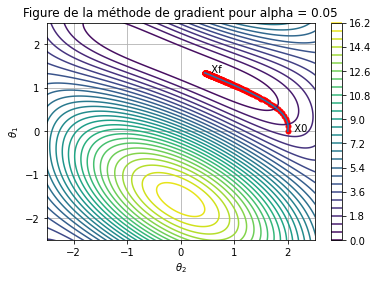

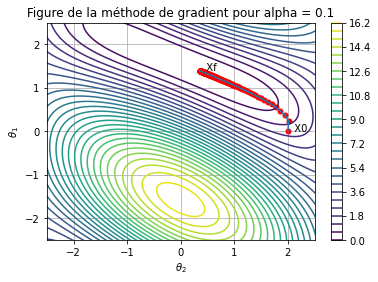

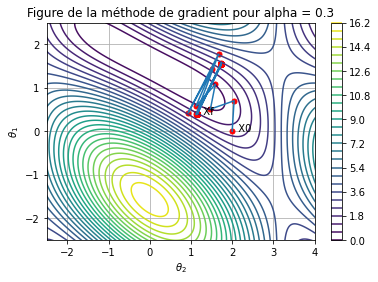

In [51]:
#Affichage de la méthode du gradient à pas fixe sans règle empirique pour différentes valeurs de alpha

plt.figure(figsize=(5, 10.5))
affichage(tabX_1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient pour alpha = 0.05')
plt.colorbar()

affichage(tabX_2)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient pour alpha = 0.1')
plt.colorbar()


affichage(tabX_3)
plt.xlim(-2.5,4)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient pour alpha = 0.3')
plt.colorbar()
plt.show()

On constate que la valeur de $\alpha$ influence beaucoup la recherche de la solution :  
Lorsque $\alpha$ est trop petit, cela prend beaucoup plus de temps d'atteindre la solution, le programme se termine avant qu'une solution satisfaisante puisse être trouvée (ceci est du à la limite $n_{max}$ dans la boucle du gradient).  
Lorsque $\alpha$ est trop grand, la méthode du gradient diverge, on oscille autour de la solution et l'on atteint jamais la solution.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')

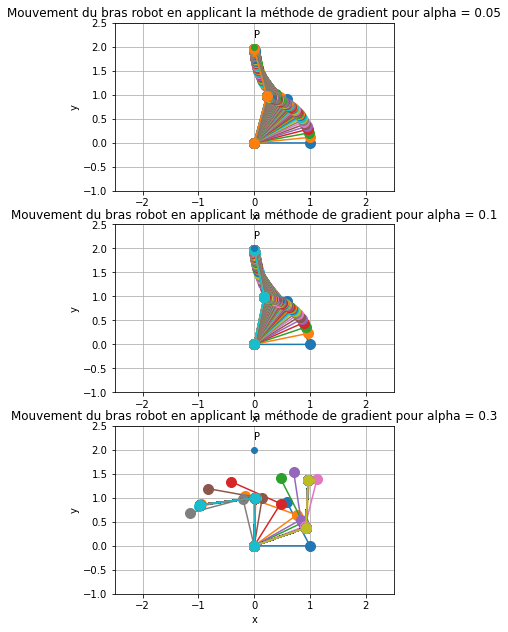

In [52]:
#Observation du mouvement du bras robot lorsque le gradien ne suit pas la règle empirique

plt.figure(figsize=(5, 10.5))
plt.subplot(3,1,1)
test(n_1, tabX_1)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.05')

plt.subplot(3,1,2)
test(n_2, tabX_2)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.1')

plt.subplot(3,1,3)
test(n_3, tabX_3)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')


In [53]:
#Utilisation de la méthode de gradient avec une règle empirique
n_11, tabX_11 = gradient(Xn, nMax, eps, alpha[0],dX)
n_21, tabX_21 = gradient(Xn, nMax, eps, alpha[1],dX)
n_31, tabX_31 = gradient(Xn, nMax, eps, alpha[2],dX)


Avec la methode du gradient à pas fixe
Solution du problème : [1.3457486040215474, 0.4477935894261496] (en radian) ou [77.10571529605691, 25.65668276713238] (en degrés)
Convergence par méthode du gradient: True en 252 itérations
Norme residu au carre :  0.002497243385770176

Avec la methode du gradient à pas fixe
Solution du problème : [1.3930922509857617, 0.354279028849978] (en radian) ou [79.81830645386374, 20.29869312309727] (en degrés)
Convergence par méthode du gradient: True en 200 itérations
Norme residu au carre :  0.0009807223106377272

Avec la methode du gradient à pas fixe
Solution du problème : [1.415790369918491, 0.3092636357386624] (en radian) ou [81.11881287159513, 17.719501084696606] (en degrés)
Convergence par méthode du gradient: True en 172 itérations
Norme residu au carre :  0.0005700147359855023


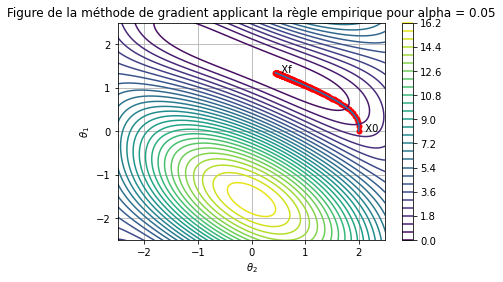

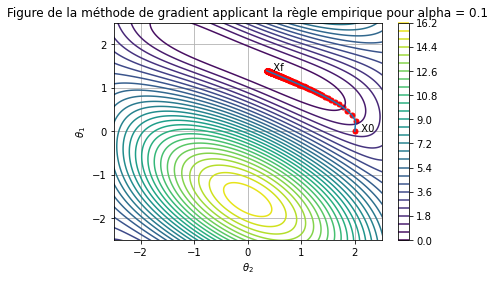

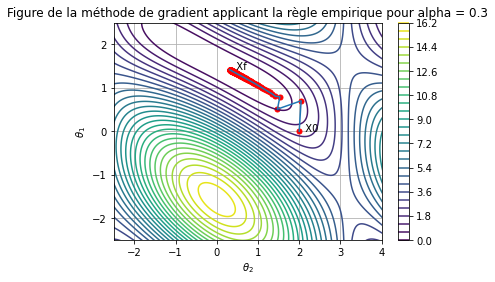

In [54]:
#Affichage de la méthode du gradient à pas fixe pour différentes valeurs de alpha

affichage(tabX_11)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient applicant la règle empirique pour alpha = 0.05')
plt.colorbar()

affichage(tabX_21)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient applicant la règle empirique pour alpha = 0.1')
plt.colorbar()

affichage(tabX_31)
plt.xlim(-2.5,4)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de gradient applicant la règle empirique pour alpha = 0.3')
plt.colorbar()
plt.show()

Grâce à la règle empirique qui permet d'assurer la descente à chaque étape, la méthode du gradient va converger pour toutes les valeurs de $\alpha$, contrairement à la méthode du gradient sans règle empirique qui n'"amortit" pas les oscillations pour les grandes valeurs de $\alpha$.

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')

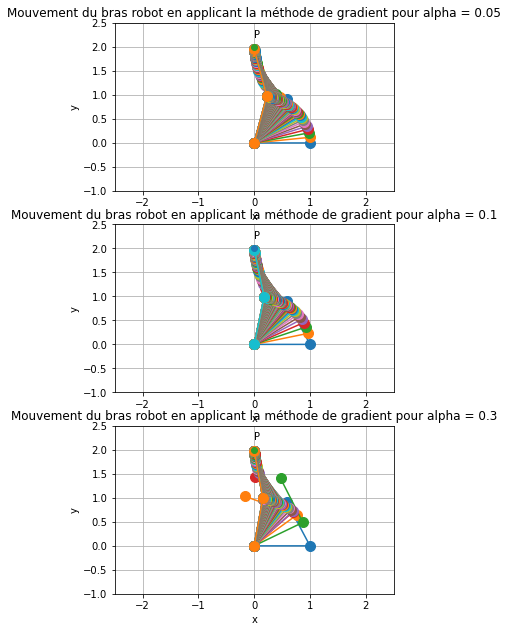

In [55]:
#Observation du mouvement du bras robot lorsque le gradien suit la règle empirique
plt.figure(figsize=(5, 10.5))
plt.subplot(3,1,1)
test(n_11, tabX_11)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.05')


plt.subplot(3,1,2)
test(n_21, tabX_21)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.1')

plt.subplot(3,1,3)
test(n_31, tabX_31)
plt.xlim(-2.5,2.5)
plt.ylim(-1,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de gradient pour alpha = 0.3')


## Exemple: importance du point de départ de la méthode de Newton 


Dans la méthode de Newton, le point de départ choisit peut changer la solution que l'on trouve ou l'évolution du programme. Nous allons donc testé le fonctionnement du programme avec plusieurs points de départ différents, et observer les différentes possibilités.

In [56]:
#Initialisation des paramètres
L1, L2 = 1, 1
L = [L1,L2]
X_0=[2,0]
X_1=[2,2]
X_2=[6,3]
eps = 1e-3
nMax = 10000

In [57]:
#Utilisation de la méthode de Newton pour différents points de départ
n_N1, tabX_N1 =newton(X_0, nMax, eps)
n_N2, tabX_N2 =newton(X_1, nMax, eps)
n_N3, tabX_N3 =newton(X_2, nMax, eps)

Avec la methode de Newton    
Convergence par méthode du gradient: True en 3 itérations
Solution du problème : [1.57079633 0.        ] (en radiant) ou [90.00000000011018, 0.0] (en degrés)
Norme residu au carre :  0.0
Avec la methode de Newton    
Convergence par méthode du gradient: True en 4 itérations
Solution du problème : [1.57079633 3.14159265] (en radiant) ou [90.00000000000001, 180.00000000000003] (en degrés)
Norme residu au carre :  4.0
Avec la methode de Newton    
Convergence par méthode du gradient: True en 5 itérations
Solution du problème : [-1.57079633  6.28318531] (en radiant) ou [-90.00000000000001, 360.0] (en degrés)
Norme residu au carre :  16.0


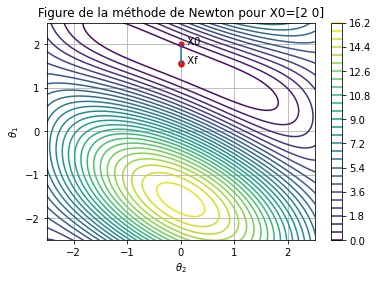

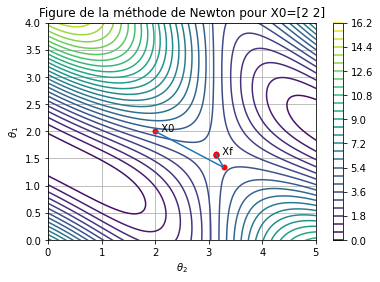

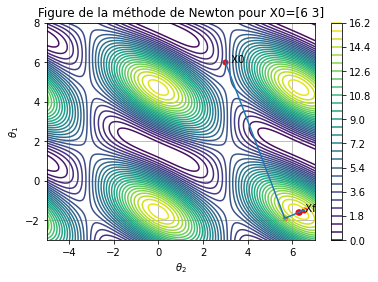

In [58]:
#Affichage de la méthode de Newton pour différents points de départ

affichage(tabX_N1) #Convergence vers un minimum
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.title('Figure de la méthode de Newton pour X0=[2 0]')
plt.colorbar()

affichage(tabX_N2) #Convergence vers un maximum
plt.xlim(0,5)
plt.ylim(0,4)
plt.title('Figure de la méthode de Newton pour X0=[2 2]')
plt.colorbar()

affichage(tabX_N3) #Convergence vers un point selle
plt.xlim(-5,7)
plt.ylim(-3,8)
plt.title('Figure de la méthode de Newton pour X0=[6 3]')
plt.colorbar()

Text(0.5, 1.0, 'Mouvement du bras robot en applicant la méthode de Newton pour X0= [6, 3]')

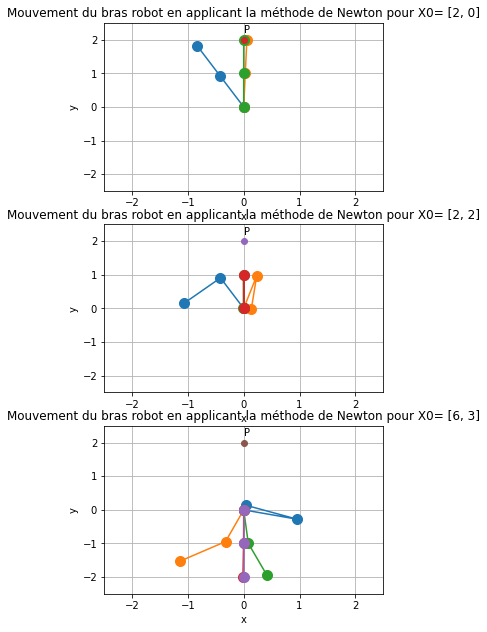

In [59]:
#Observation du mouvement du bras robot avec la méthode de Newton pour différents points
plt.figure(figsize=(5, 10.5))
plt.subplot(3, 1, 1)
test(n_N1, tabX_N1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton pour X0= [2, 0]')
 
plt.subplot(3, 1, 2)
test(n_N2, tabX_N2)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton pour X0= [2, 2]')

plt.subplot(3, 1, 3)
test(n_N3, tabX_N3)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.plot(0,2,'o')
plt.text(0, 2.2, 'P')
plt.title('Mouvement du bras robot en applicant la méthode de Newton pour X0= [6, 3]')


En partant de différents points de départ, nous observons que la méthode de Newton converge soit vers un minimum, un point selle ou un maximum.  
Afin d'avoir un bon fonctionnement de la méthode de Newton, il est nécessaire de choisir un point de départ $\theta_0$ assez proche de la solution, car on constate que si le point de départ est trop éloigné, le minimum ne sera pas trouvé. Il faut donc déjà une idée du point solution $\theta$.

## Conclusion
&emsp;Les méthodes root et minimize sont très précises et très simples à implémenter.  
&emsp;Quant au gradient, avec la règle empirique cela permet d'avoir une précision assez précis et assuré de converger. Sans la règle empirique, il faudrait adapter alpha pour qu'il converge rapidement et vers un minimum.   
&emsp;La méthode de Newton est moins précise, mais beaucoup plus rapide (faible nombre d'itérations) que la méthode du gradient. De plus, le point de départ est très important, comme la solution cherche juste à tendre vers un point critique. Donc la méthode de Newton peut tendre vers un minimum, un maximum ou un point selle selon le point de départ choisi.  
  
&emsp;D'autre part, il faut s'assurer que le problème possède bien une solution avant d'implémenter les méthodes, et vérifier que la norme du résidu est nulle afin d'avoir une racine et non pas un minimum puisque certaines méthodes ne permettent pas de savoir si c'est bien le cas, et renvoie juste la solution trouvée. En effet, un résidu non nul ne correspond pas à une racine, et certaines méthodes peuvent renvoyer un point critique où la fonction n'est pas nulle. Donc cela ne correspond pas à la solution que l'on recherche.

  
&emsp;Enfin, on peut prendre la mesure principale de la solution trouvée afin de régler le bras robot, puisque certaines solutions lui ferait faire des tours de trop car nos solutions sont toujours $2\pi$ - périodiques.